<a href="https://colab.research.google.com/github/shohan007/ML-Engineered-Tissue-Evaluation/blob/main/DIS_Biomaterial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library Imports

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pylab as py

#sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve, ShuffleSplit
from sklearn.metrics import f1_score, make_scorer, accuracy_score, confusion_matrix, classification_report


from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
#from catboost import CatBoostClassifier

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#!pip install catboost

     |████████████████████████████████| 65.8MB 53kB/s 


In [4]:
#Reading the Dataset
df=pd.read_excel('/content/drive/MyDrive/DIS Data/biomaterial DIS.xlsx')
df.drop(index=658,inplace=True)
df.head()

,Events,174kHz,224kHz,287kHz,368kHz,473kHz,607kHz,779kHz,1000kHz,1284kHz,1648kHz,2115kHz,Time Period,Biomaterial,Digit,deltaP,Avg
0,Feed,0.898,0.618,0.356,0.338,0.218,0.021,0.029,-0.081,-0.180,-0.280,-0.130,2,Collagen,1,1.178,1.1421
1,0,0.830,0.501,0.309,0.259,0.243,-0.054,0.009,-0.085,-0.272,-0.295,-0.137,2,Collagen,1,1.125,NaN
2,0,0.876,0.451,0.393,0.263,0.199,0.059,0.005,-0.074,-0.224,-0.220,-0.139,2,Collagen,1,1.100,NaN
3,0,0.718,0.599,0.328,0.108,0.232,0.043,-0.071,-0.067,-0.174,-0.289,-0.184,2,Collagen,1,1.007,NaN
4,0,0.685,0.348,0.363,0.212,0.133,0.017,-0.042,-0.031,-0.174,-0.242,-0.180,2,Collagen,1,0.927,NaN


In [6]:
#sm.qqplot(df.iloc[:,1:12], line ='45')
#py.show()

In [8]:
X=df[['174kHz', '224kHz', '287kHz', '368kHz', '473kHz', '607kHz', '779kHz', '1000kHz', '1284kHz', '1648kHz', '2115kHz']]
Y=df[['Biomaterial','Time Period']]

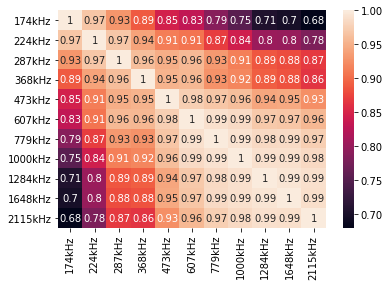

In [9]:
#Heatmap
sns.heatmap(X.corr(), annot=True);

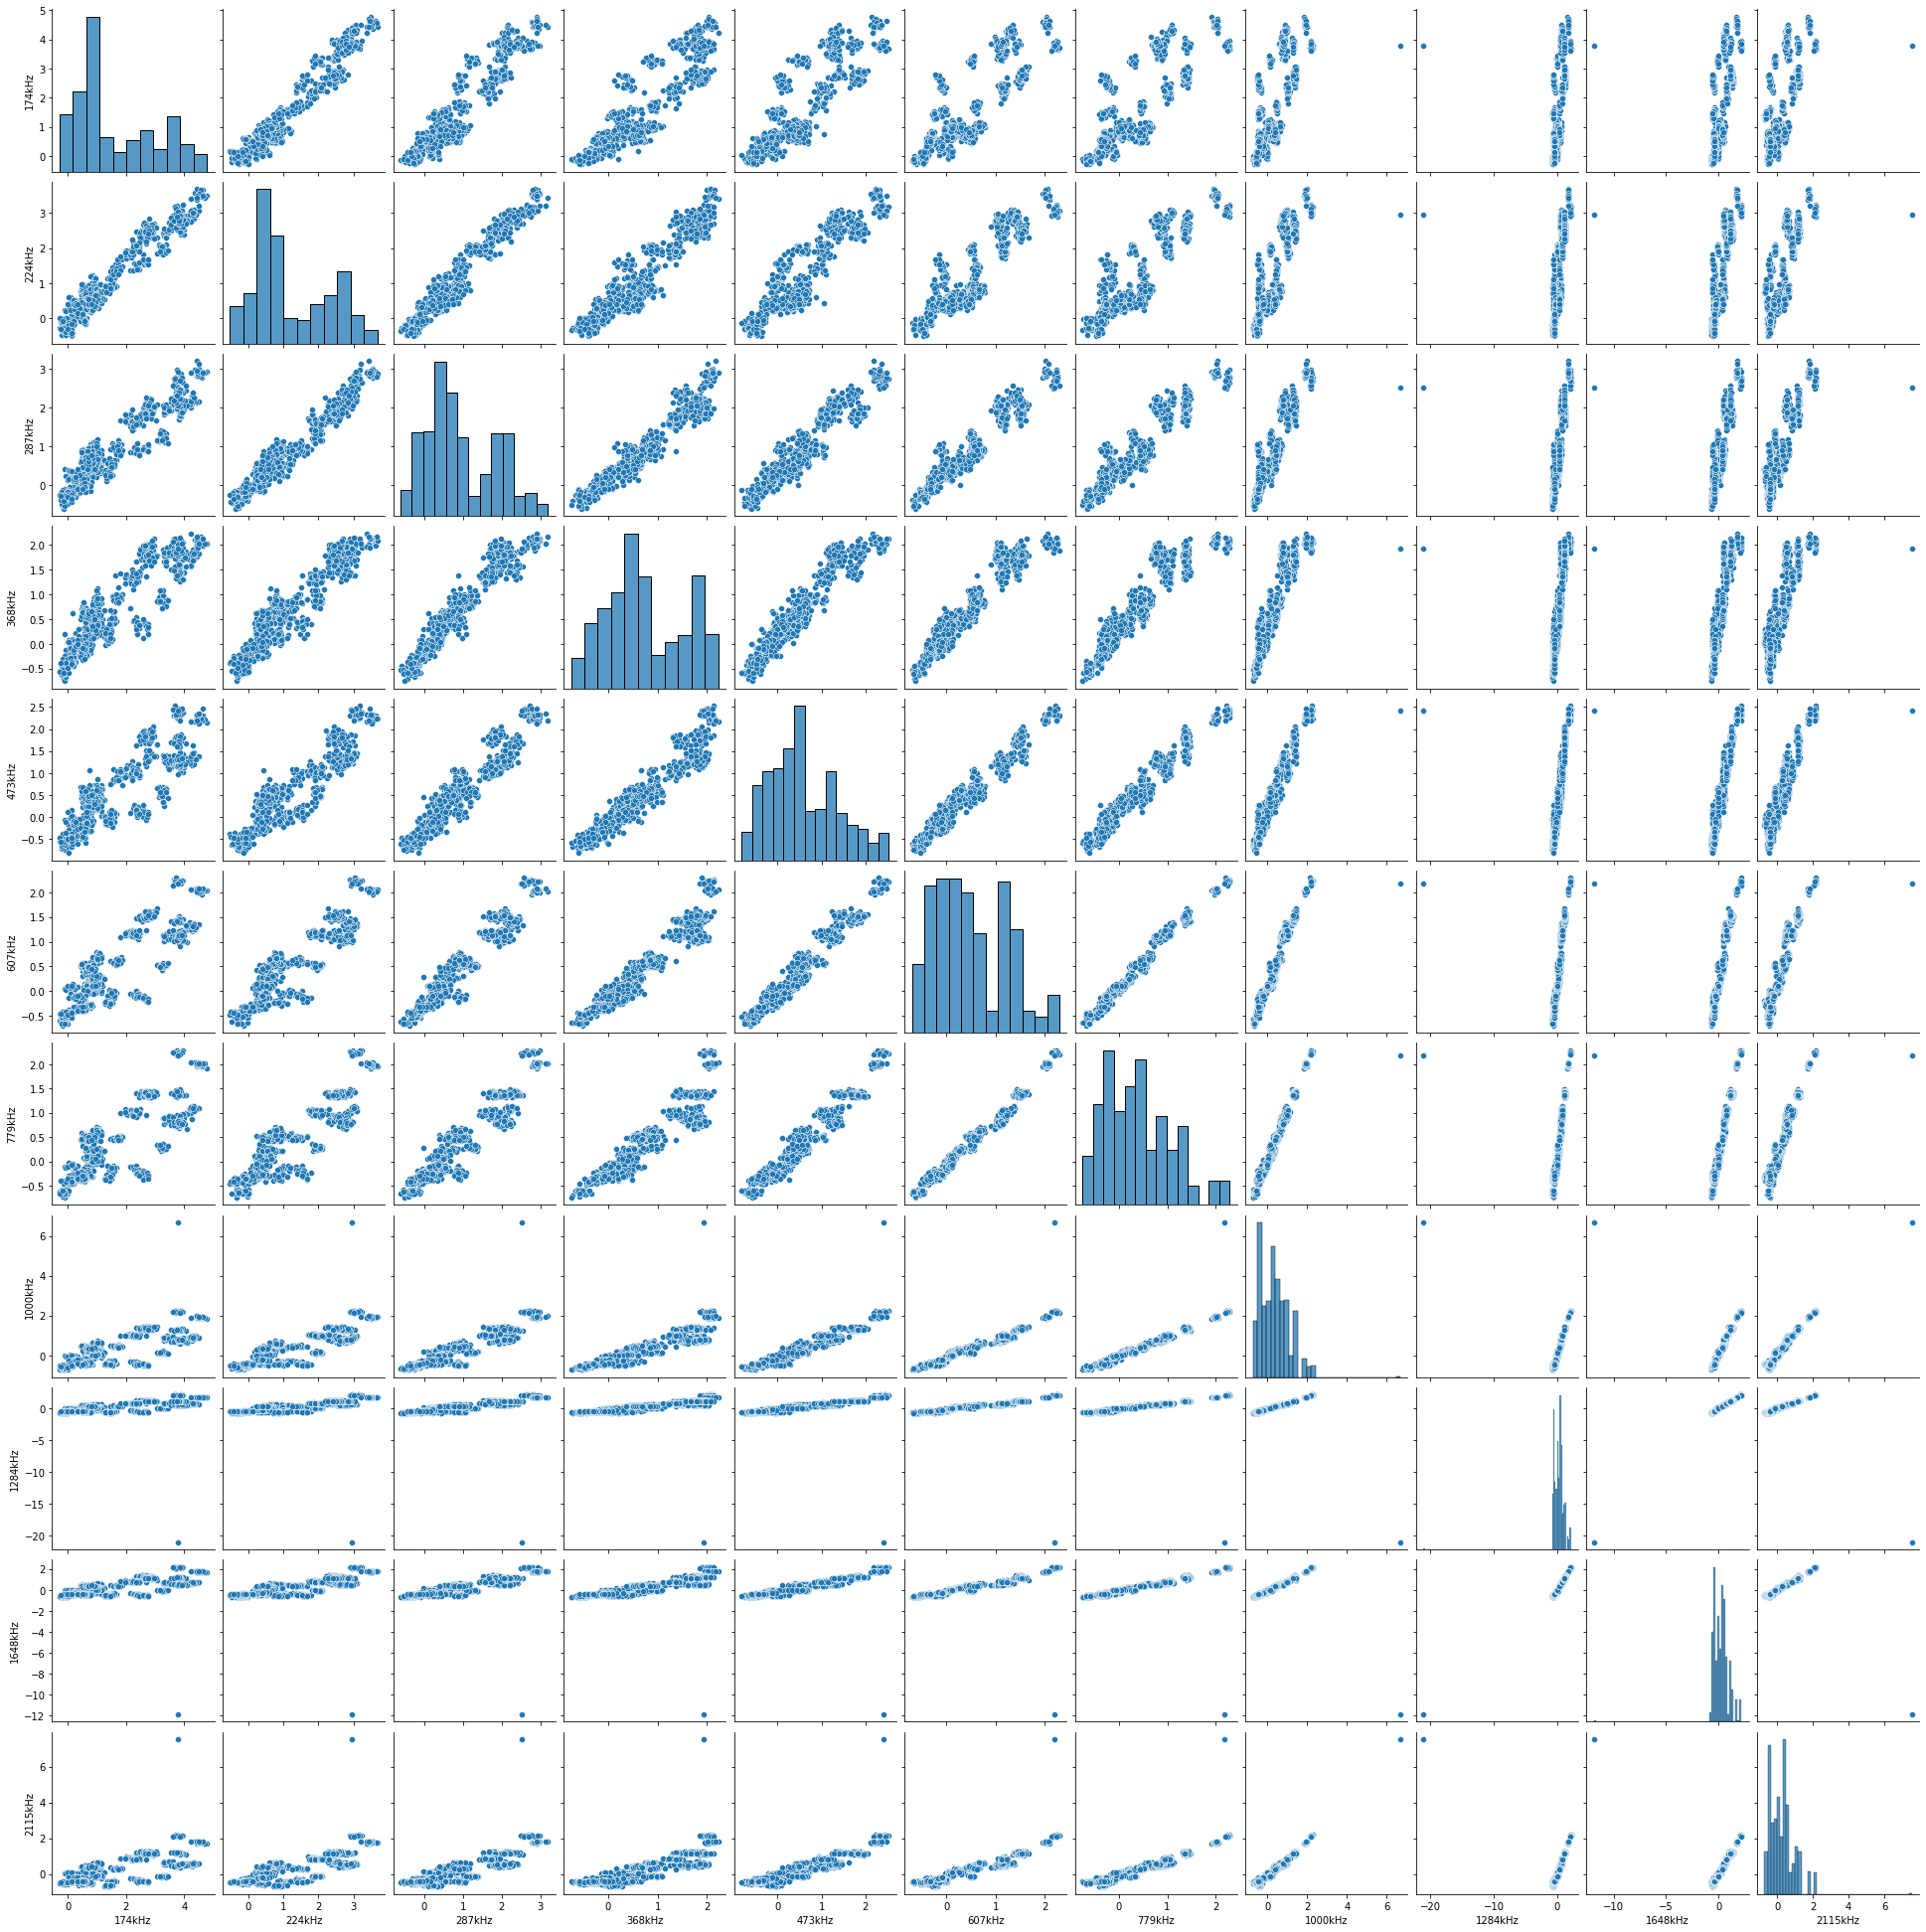

In [ ]:
sns.pairplot(X)

#Data Preprocessing

In [10]:
#Encoding the categorical Y
le1=LabelEncoder()
le2=LabelEncoder()
scaler=StandardScaler()

X_transformed=scaler.fit_transform(X)
Y_transformed_cell_type=le1.fit_transform(Y['Biomaterial'])
Y_transformed_time=le2.fit_transform(Y['Time Period'])

#Utility Functions

In [11]:
# confusion matrix
def print_confusion_matrix(confusion_matrix, class_names, figsize = (6,4), fontsize=14):
    
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap='viridis')
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [12]:
#Grid search

def grid_search(clf, parameters, scorer, train_data, test_data, cv=5):

    #Perform grid search on the classifier using 'scorer' as the scoring method.
    grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

    # Fit the grid search object to the training data and find the optimal parameters.
    grid_fit = grid_obj.fit(train_data[0], train_data[1])

    # Get the estimator.
    best_clf = grid_fit.best_estimator_

    # Fit the new model.
    best_clf.fit(train_data[0], train_data[1])

    # Make predictions using the new model.
    best_train_predictions = best_clf.predict(train_data[0])
    best_test_predictions = best_clf.predict(test_data[0])

    # Calculate the acc score of the new model.
    print('The training acc Score is', accuracy_score(best_train_predictions, train_data[1]))
    print('The testing acc Score is', accuracy_score(best_test_predictions, test_data[1]))
    print('The testing acc Score STD', np.mean(grid_obj.cv_results_['std_test_score']))


    # Let's also explore what parameters ended up being used in the new model.
    return grid_obj, best_clf

#Function of SML models

In [13]:
# Logistics Regression with cross validation
def logistic_cv(train_data, test_data, class_names, cv=5):
    
    # stringify class names
    class_names = list(map(str, class_names))
    
    # init model and params
    parameters = {'C':[1.0, 10, 100, 1000]}
    scorer = make_scorer(accuracy_score)
    logreg = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=10_000) 
    
    # grid search
    grid_obj, best_clf = grid_search(logreg, parameters, scorer, train_data, test_data, cv)
    
    # confusion matrix
    preds = best_clf.predict(test_data[0])
    print(classification_report(test_data[1], preds,target_names=class_names))
    cm = confusion_matrix(test_data[1], preds)
    print_confusion_matrix(cm, class_names=class_names)

In [14]:
# Decision Tree Classification with cross validation
def dtree_cv(train_data, test_data, class_names, cv=5):
    
    # stringify class names
    class_names = list(map(str, class_names))
    
    # init model and params
    dtree = DecisionTreeClassifier()
    parameters = {'max_depth':[2,4,6,8,10],'min_samples_leaf':[2,4,6,8,10], 'min_samples_split':[2,4,6,8,10]}
    scorer = make_scorer(accuracy_score)


    # grid search
    grid_obj, best_clf = grid_search(dtree, parameters, scorer, train_data, test_data, cv)
    
    # confusion matrix
    preds = best_clf.predict(test_data[0])
    print(classification_report(test_data[1], preds,target_names=class_names))
    cm = confusion_matrix(test_data[1], preds)
    print_confusion_matrix(cm, class_names=class_names)

In [15]:
# Support vector machine with cross validation
def svc_cv(train_data, test_data, class_names, cv=5):
    
    # stringify class names
    class_names = list(map(str, class_names))
    
    # init model and params
    svc = SVC() 
    parameters = {'kernel':['poly', 'rbf'],'C':[0.1, 1, 10], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}
    scorer = make_scorer(accuracy_score)
   

    # grisearch
    grid_obj, best_clf = grid_search(svc, parameters, scorer, train_data, test_data, cv)
    
    # confusion matrix
    preds = best_clf.predict(test_data[0])
    print(classification_report(test_data[1], preds,target_names=class_names))
    cm = confusion_matrix(test_data[1], preds)
    print_confusion_matrix(cm, class_names=class_names)

In [16]:
# K Nearest Neighbours with cross validation
def knn_cv(train_data, test_data, class_names, cv=5):
    
    # stringify class names
    class_names = list(map(str, class_names))
    
    # init model and params
    knn = KNeighborsClassifier()
    neighbors = list(range(1, 30))  
    parameters = {'n_neighbors': neighbors}
    scorer = make_scorer(accuracy_score)
 
    # grisearch
    grid_obj, best_clf = grid_search(knn, parameters, scorer, train_data, test_data, cv)
    
    # confusion matrix
    preds = best_clf.predict(test_data[0])
    print(classification_report(test_data[1], preds,target_names=class_names))
    cm = confusion_matrix(test_data[1], preds)
    print_confusion_matrix(cm, class_names=class_names)

In [17]:
# Random Forest with cross validation
def rf_cv(train_data, test_data, class_names, cv=5):
    
    # stringify class names
    class_names = list(map(str, class_names))
    
    # init model and params
    rf= RandomForestClassifier(n_estimators = 10, criterion = 'entropy')
    parameters = {}
    scorer = make_scorer(accuracy_score)

    # grisearch
    grid_obj, best_clf = grid_search(rf, parameters, scorer, train_data, test_data, cv)
    
    # confusion matrix
    preds = best_clf.predict(test_data[0])
    print(classification_report(test_data[1], preds,target_names=class_names))
    cm = confusion_matrix(test_data[1], preds)
    print_confusion_matrix(cm, class_names=class_names)

In [18]:
# Naive Bayes with cross validation
def nb_cv(train_data, test_data, class_names, cv=5):
    
    # stringify class names
    class_names = list(map(str, class_names))
    
    # init model and params
    nb= GaussianNB()
    parameters = {}
    scorer = make_scorer(accuracy_score)

    # grisearch
    grid_obj, best_clf = grid_search(nb, parameters, scorer, train_data, test_data, cv)
    
    # confusion matrix
    preds = best_clf.predict(test_data[0])
    print(classification_report(test_data[1], preds,target_names=class_names))
    cm = confusion_matrix(test_data[1], preds)
    print_confusion_matrix(cm, class_names=class_names)

In [19]:
# XG Boosting Classifier with cross validation
def xgb_cv(train_data, test_data, class_names, cv=5):
    
    # stringify class names
    class_names = list(map(str, class_names))
    
    # init model and params
    xgb= XGBClassifier()
    parameters = {}
    scorer = make_scorer(accuracy_score)

    # grisearch
    grid_obj, best_clf = grid_search(xgb, parameters, scorer, train_data, test_data, cv)
    
    # confusion matrix
    preds = best_clf.predict(test_data[0])
    print(classification_report(test_data[1], preds,target_names=class_names))
    cm = confusion_matrix(test_data[1], preds)
    print_confusion_matrix(cm, class_names=class_names)

In [20]:
# CAT Boosting Classifier with cross validation
def catb_cv(train_data, test_data, class_names, cv=5):
    
    # stringify class names
    class_names = list(map(str, class_names))
    
    # init model and params
    catb= CatBoostClassifier()
    scorer = make_scorer(accuracy_score)
    parameter={}

    # grisearch
    grid_obj, best_clf = grid_search(catb,parameter, scorer, train_data, test_data, cv)
    
    # confusion matrix
    preds = best_clf.predict(test_data[0])
    print(classification_report(test_data[1], preds,target_names=class_names))
    cm = confusion_matrix(test_data[1], preds)
    print_confusion_matrix(cm, class_names=class_names)

#Biomaterial Classification

In [22]:
# Train Test Dataset
trainx, testx, trainy, testy = train_test_split(X_transformed,
                                                Y_transformed_cell_type,
                                                test_size=0.3,
                                                random_state=42,
                                                stratify=Y_transformed_cell_type)


# create class names
class_names = np.unique(Y['Biomaterial'])
class_names = [c for c in class_names]

In [23]:
class_names

['Alginate', 'Collagen', 'Gelma']

The training acc Score is 0.9702797202797203
The testing acc Score is 0.9308943089430894
The testing acc Score STD 0.02107245466977458
              precision    recall  f1-score   support

    Alginate       0.93      0.85      0.89        78
    Collagen       0.86      0.94      0.90        78
       Gelma       1.00      1.00      1.00        90

    accuracy                           0.93       246
   macro avg       0.93      0.93      0.93       246
weighted avg       0.93      0.93      0.93       246



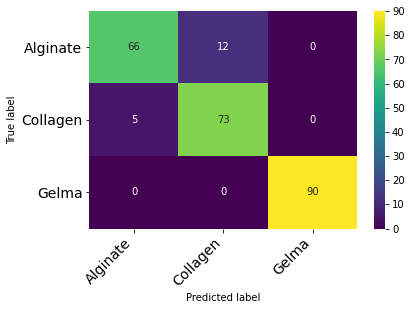

In [25]:
# logreg
logistic_cv((trainx, trainy), (testx, testy), class_names, 10)

The training acc Score is 0.9947552447552448
The testing acc Score is 0.9878048780487805
The testing acc Score STD 0.018139785173308356
              precision    recall  f1-score   support

    Alginate       1.00      0.96      0.98        78
    Collagen       0.97      1.00      0.99        78
       Gelma       0.99      1.00      0.99        90

    accuracy                           0.99       246
   macro avg       0.99      0.99      0.99       246
weighted avg       0.99      0.99      0.99       246



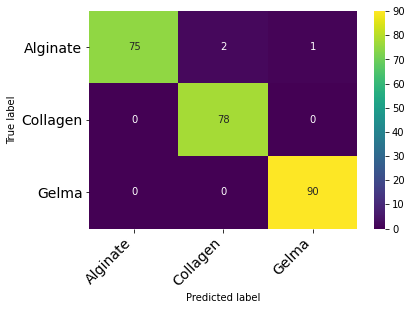

In [26]:
# dtree
dtree_cv((trainx, trainy), (testx, testy), class_names, 10)

The training acc Score is 1.0
The testing acc Score is 0.9959349593495935
The testing acc Score STD 0.014840410835393827
              precision    recall  f1-score   support

    Alginate       1.00      0.99      0.99        78
    Collagen       0.99      1.00      0.99        78
       Gelma       1.00      1.00      1.00        90

    accuracy                           1.00       246
   macro avg       1.00      1.00      1.00       246
weighted avg       1.00      1.00      1.00       246



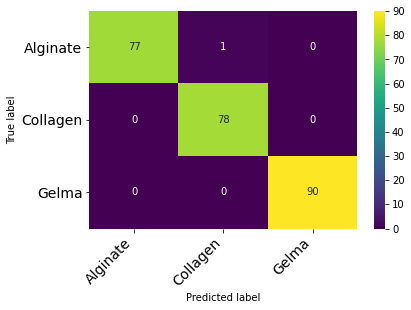

In [31]:
# svc
svc_cv((trainx, trainy), (testx, testy), class_names, 10)

The training acc Score is 1.0
The testing acc Score is 1.0
The testing acc Score STD 0.011117671712487322
              precision    recall  f1-score   support

    Alginate       1.00      1.00      1.00        78
    Collagen       1.00      1.00      1.00        78
       Gelma       1.00      1.00      1.00        90

    accuracy                           1.00       246
   macro avg       1.00      1.00      1.00       246
weighted avg       1.00      1.00      1.00       246



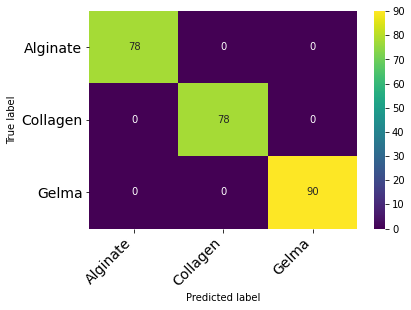

In [28]:
# knn
knn_cv((trainx, trainy), (testx, testy), class_names, 10)

The training acc Score is 1.0
The testing acc Score is 0.9878048780487805
The testing acc Score STD 0.017936766995208613
              precision    recall  f1-score   support

    Alginate       1.00      0.96      0.98        78
    Collagen       0.96      1.00      0.98        78
       Gelma       1.00      1.00      1.00        90

    accuracy                           0.99       246
   macro avg       0.99      0.99      0.99       246
weighted avg       0.99      0.99      0.99       246



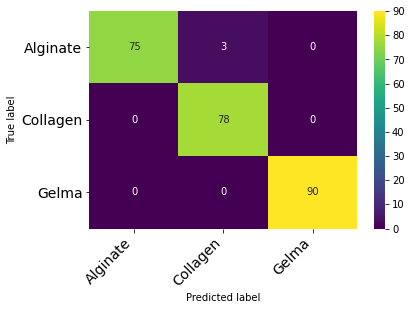

In [29]:
# rf
rf_cv((trainx, trainy), (testx, testy), class_names, 10)

The training acc Score is 0.9335664335664335
The testing acc Score is 0.9186991869918699
The testing acc Score STD 0.045603946954410814
              precision    recall  f1-score   support

    Alginate       0.88      0.87      0.88        78
    Collagen       0.86      0.88      0.87        78
       Gelma       1.00      0.99      0.99        90

    accuracy                           0.92       246
   macro avg       0.92      0.92      0.92       246
weighted avg       0.92      0.92      0.92       246



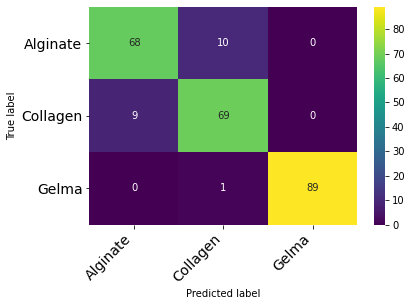

In [30]:
# nb
nb_cv((trainx, trainy), (testx, testy), class_names, 10)

The training acc Score is 1.0
The testing acc Score is 0.9878048780487805
The testing acc Score STD 0.016899588501269328
              precision    recall  f1-score   support

    Alginate       1.00      0.96      0.98        78
    Collagen       0.96      1.00      0.98        78
       Gelma       1.00      1.00      1.00        90

    accuracy                           0.99       246
   macro avg       0.99      0.99      0.99       246
weighted avg       0.99      0.99      0.99       246



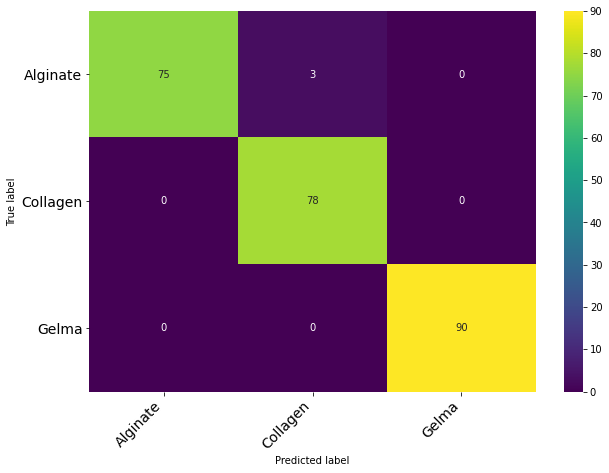

In [ ]:
# xgb
xgb_cv((trainx, trainy), (testx, testy), class_names, 5)

Streaming output truncated to the last 5000 lines.
17:	learn: 0.3027916	total: 166ms	remaining: 9.05s
18:	learn: 0.2863841	total: 174ms	remaining: 9.01s
19:	learn: 0.2726776	total: 182ms	remaining: 8.94s
20:	learn: 0.2596021	total: 191ms	remaining: 8.88s
21:	learn: 0.2443615	total: 199ms	remaining: 8.83s
22:	learn: 0.2334267	total: 207ms	remaining: 8.78s
23:	learn: 0.2220176	total: 215ms	remaining: 8.73s
24:	learn: 0.2119707	total: 223ms	remaining: 8.7s
25:	learn: 0.2008336	total: 231ms	remaining: 8.66s
26:	learn: 0.1906933	total: 239ms	remaining: 8.62s
27:	learn: 0.1811799	total: 247ms	remaining: 8.57s
28:	learn: 0.1729039	total: 257ms	remaining: 8.61s
29:	learn: 0.1659409	total: 266ms	remaining: 8.59s
30:	learn: 0.1573072	total: 274ms	remaining: 8.56s
31:	learn: 0.1501391	total: 282ms	remaining: 8.53s
32:	learn: 0.1440900	total: 290ms	remaining: 8.51s
33:	learn: 0.1387755	total: 298ms	remaining: 8.48s
34:	learn: 0.1323056	total: 306ms	remaining: 8.45s
35:	learn: 0.1282316	total: 319m

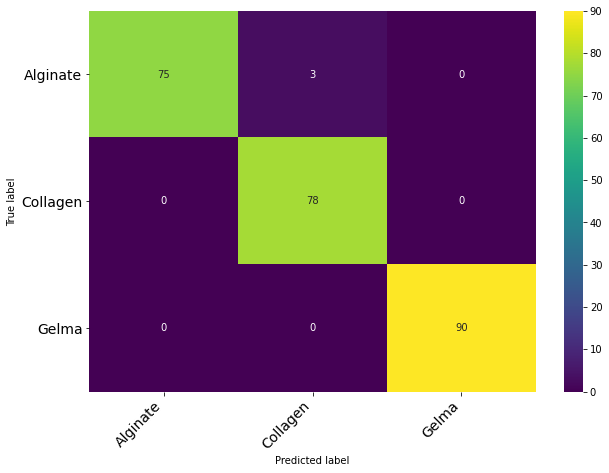

In [ ]:
# catb
#catb_cv((trainx, trainy), (testx, testy), class_names, 5)

#Time Point Analysis

In [32]:

# split the dataset
trainx, testx, trainy, testy = train_test_split(X_transformed,
                                                Y_transformed_time,
                                                test_size=0.3,
                                                random_state=42,
                                                stratify=Y_transformed_cell_type)


# create class names
class_names = np.unique(Y['Time Period'])
class_names = [str(c)+'h' for c in class_names]

In [33]:
class_names

['2h', '24h', '48h', '72h', '96h']

The training acc Score is 0.7762237762237763
The testing acc Score is 0.7195121951219512
The testing acc Score STD 0.04089949837883047
              precision    recall  f1-score   support

          2h       0.73      0.79      0.76        24
         24h       0.69      0.79      0.74        48
         48h       0.90      0.91      0.90        57
         72h       0.66      0.53      0.59        55
         96h       0.62      0.63      0.62        62

    accuracy                           0.72       246
   macro avg       0.72      0.73      0.72       246
weighted avg       0.72      0.72      0.72       246



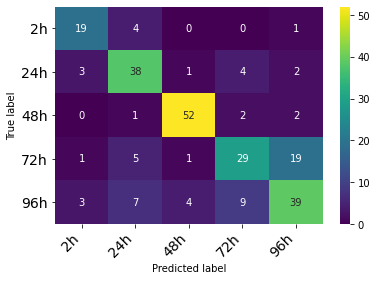

In [42]:
# logreg
logistic_cv((trainx, trainy), (testx, testy), class_names, 10)

The training acc Score is 0.9685314685314685
The testing acc Score is 0.8861788617886179
The testing acc Score STD 0.045850945884520836
              precision    recall  f1-score   support

          2h       0.69      0.83      0.75        24
         24h       0.89      0.88      0.88        48
         48h       0.93      0.95      0.94        57
         72h       0.91      0.78      0.84        55
         96h       0.91      0.95      0.93        62

    accuracy                           0.89       246
   macro avg       0.87      0.88      0.87       246
weighted avg       0.89      0.89      0.89       246



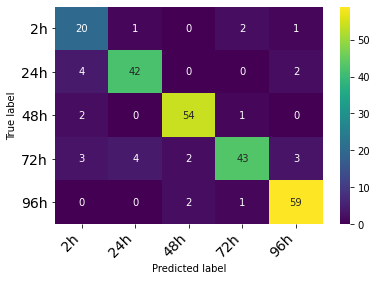

In [44]:
# dtree
dtree_cv((trainx, trainy), (testx, testy), class_names, 10)

The training acc Score is 1.0
The testing acc Score is 0.9796747967479674
The testing acc Score STD 0.03456004199039015
              precision    recall  f1-score   support

          2h       1.00      1.00      1.00        24
         24h       0.96      1.00      0.98        48
         48h       0.98      0.96      0.97        57
         72h       0.98      0.96      0.97        55
         96h       0.98      0.98      0.98        62

    accuracy                           0.98       246
   macro avg       0.98      0.98      0.98       246
weighted avg       0.98      0.98      0.98       246



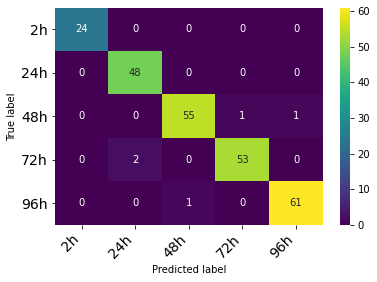

In [45]:
# svc
svc_cv((trainx, trainy), (testx, testy), class_names, 10)

The training acc Score is 1.0
The testing acc Score is 0.975609756097561
The testing acc Score STD 0.0397615016378821
              precision    recall  f1-score   support

          2h       1.00      1.00      1.00        24
         24h       0.92      1.00      0.96        48
         48h       0.97      1.00      0.98        57
         72h       1.00      0.93      0.96        55
         96h       1.00      0.97      0.98        62

    accuracy                           0.98       246
   macro avg       0.98      0.98      0.98       246
weighted avg       0.98      0.98      0.98       246



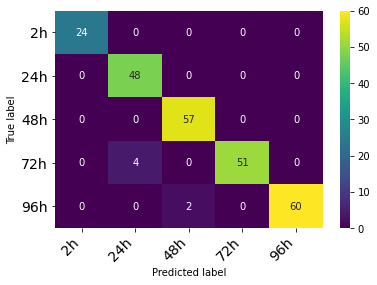

In [47]:
# knn
knn_cv((trainx, trainy), (testx, testy),class_names, 10)

The training acc Score is 0.9965034965034965
The testing acc Score is 0.9512195121951219
The testing acc Score STD 0.0034504488466765852
              precision    recall  f1-score   support

          2h       1.00      0.96      0.98        24
         24h       0.87      0.98      0.92        48
         48h       0.97      0.98      0.97        57
         72h       0.98      0.91      0.94        55
         96h       0.97      0.94      0.95        62

    accuracy                           0.95       246
   macro avg       0.96      0.95      0.95       246
weighted avg       0.95      0.95      0.95       246



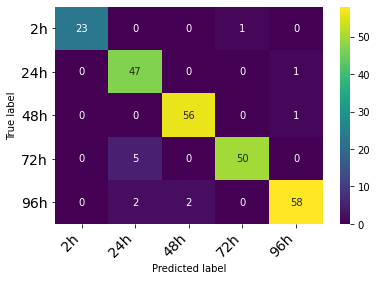

In [49]:
# rf
rf_cv((trainx, trainy), (testx, testy), class_names, 10)

The training acc Score is 0.2727272727272727
The testing acc Score is 0.2845528455284553
The testing acc Score STD 0.035288155003576425
              precision    recall  f1-score   support

          2h       0.35      0.50      0.41        24
         24h       0.03      0.04      0.04        48
         48h       0.47      0.33      0.39        57
         72h       0.24      0.24      0.24        55
         96h       0.45      0.39      0.42        62

    accuracy                           0.28       246
   macro avg       0.31      0.30      0.30       246
weighted avg       0.32      0.28      0.30       246



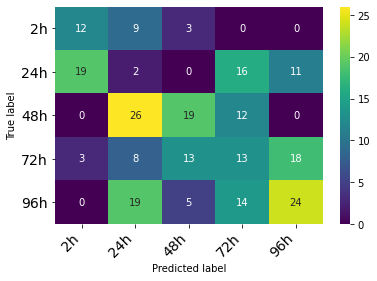

In [51]:
# nb
nb_cv((trainx, trainy), (testx, testy), class_names, 10)

The training acc Score is 1.0
The testing acc Score is 0.9512195121951219
The testing acc Score STD 0.030641042729292356
              precision    recall  f1-score   support

          2h       0.92      0.92      0.92        24
         24h       0.96      0.96      0.96        48
         48h       0.96      0.93      0.95        57
         72h       0.96      0.96      0.96        55
         96h       0.94      0.97      0.95        62

    accuracy                           0.95       246
   macro avg       0.95      0.95      0.95       246
weighted avg       0.95      0.95      0.95       246



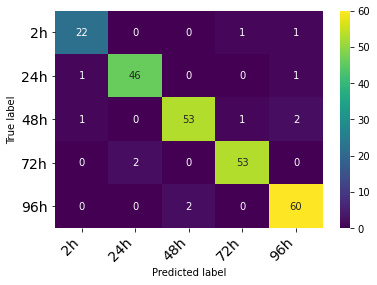

In [53]:
# xgb
xgb_cv((trainx, trainy), (testx, testy), class_names, 10)

In [41]:
# catb
#catb_cv((trainx, trainy), (testx, testy), class_names, 5)

#ANN

#Time detection with ANN

In [54]:
import tensorflow as tf
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Activation, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, BatchNormalization, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from imutils import paths

In [55]:
#Encoding the categorical Y
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
lb1=LabelBinarizer()
lb2=LabelBinarizer()
lb3=LabelBinarizer()
scaler=StandardScaler()
#Y=df[['Biomaterial','Time Period']]
X_transformed=scaler.fit_transform(X)
Y_transformed_biomaterial_ann = lb1.fit_transform(Y['Biomaterial'])
Y_transformed_time_ann=lb2.fit_transform(Y['Time Period'])

In [57]:
# split the dataset
trainx, testx, trainy, testy = train_test_split(X_transformed,
                                                Y_transformed_time_ann,
                                                test_size=0.3,
                                                random_state=42)

In [ ]:
trainy

array([[0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0]])

In [58]:
# create the ANN model - time
model = Sequential()
model.add(Dense(units=16, input_shape=(X_transformed.shape[1],)))
model.add(Activation("relu"))
# model.add(Dense(units=16))
# model.add(Activation("relu"))
model.add(Dense(units=12))
model.add(Activation("relu"))
model.add(Dense(units=len(lb2.classes_)))
model.add(Activation("softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                192       
_________________________________________________________________
activation (Activation)      (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                204       
_________________________________________________________________
activation_1 (Activation)    (None, 12)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 65        
_________________________________________________________________
activation_2 (Activation)    (None, 5)                 0         
Total params: 461
Trainable params: 461
Non-trainable params: 0
__________________________________________________________

In [59]:
# init some global variables
epochs = 1000
init_lr = 1e-3


# compile the model and start training
opt = Adam(learning_rate=init_lr, decay=init_lr/epochs)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

H = model.fit(trainx, trainy,
              validation_data=(testx, testy),
              verbose=1,
              epochs=epochs)

Epoch 1/1000
18/18 [==============================] - 1s 33ms/step - loss: 1.6399 - accuracy: 0.2539 - val_loss: 1.6002 - val_accuracy: 0.2358
Epoch 2/1000
18/18 [==============================] - 0s 5ms/step - loss: 1.5779 - accuracy: 0.2354 - val_loss: 1.5782 - val_accuracy: 0.2154
Epoch 3/1000
18/18 [==============================] - 0s 5ms/step - loss: 1.5556 - accuracy: 0.2771 - val_loss: 1.5560 - val_accuracy: 0.2602
Epoch 4/1000
18/18 [==============================] - 0s 4ms/step - loss: 1.5414 - accuracy: 0.3034 - val_loss: 1.5350 - val_accuracy: 0.2602
Epoch 5/1000
18/18 [==============================] - 0s 4ms/step - loss: 1.5048 - accuracy: 0.3548 - val_loss: 1.5144 - val_accuracy: 0.2967
Epoch 6/1000
18/18 [==============================] - 0s 5ms/step - loss: 1.5037 - accuracy: 0.3291 - val_loss: 1.4919 - val_accuracy: 0.3089
Epoch 7/1000
18/18 [==============================] - 0s 5ms/step - loss: 1.4662 - accuracy: 0.3768 - val_loss: 1.4692 - val_accuracy: 0.3333
Epoch

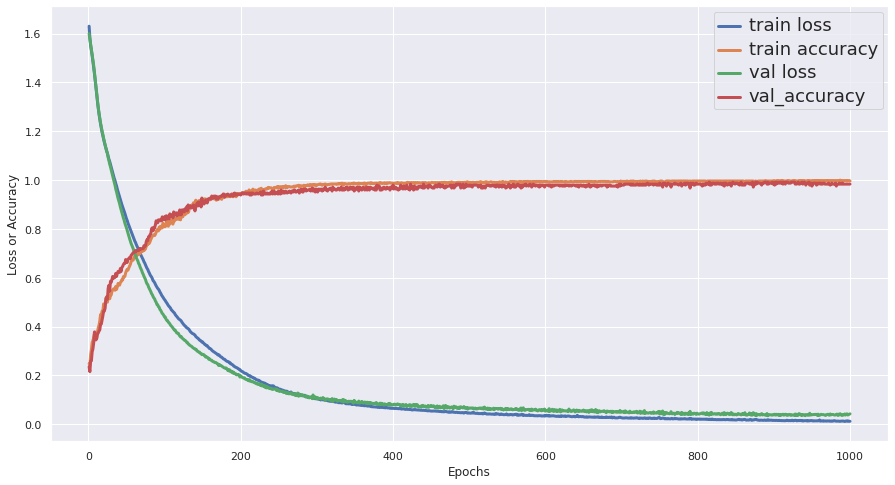

In [60]:
# plot the performance
epoch_num = range(1,epochs+1)
loss = H.history['loss']
accuracy = H.history['accuracy']
val_loss = H.history['val_loss']
val_accuracy = H.history['val_accuracy']
plot_df = pd.DataFrame(data=np.c_[epoch_num,
                                  loss,accuracy,
                                  val_loss,
                                  val_accuracy],
                       columns=['epochs','loss', 'accuracy', 'val_loss', 'val_accuracy'])

# do the actual plots
sns.set(font_scale=1)
f, ax = plt.subplots(1, 1, figsize=(15,8))
sns.lineplot(data=plot_df, x='epochs', y='loss', ax=ax, label='train loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='accuracy', ax=ax, label='train accuracy', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_loss', ax=ax, label='val loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_accuracy', ax=ax, label='val_accuracy', linewidth=3)
ax.set_ylabel('Loss or Accuracy')
ax.set_xlabel('Epochs')
plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text

In [61]:
# calculate the classification report
from sklearn.metrics import classification_report
preds = model.predict(testx)
print(classification_report(testy.argmax(axis=1),
                            preds.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        28
           1       1.00      0.97      0.98        64
           2       1.00      0.98      0.99        53
           3       0.98      1.00      0.99        50
           4       0.96      1.00      0.98        51

    accuracy                           0.98       246
   macro avg       0.98      0.98      0.98       246
weighted avg       0.98      0.98      0.98       246



#Biomaterial detection with ANN

In [62]:
# split the dataset
trainx, testx, trainy, testy = train_test_split(X_transformed,
                                                Y_transformed_biomaterial_ann,
                                                test_size=0.3,
                                                random_state=42)

In [63]:
# create the ANN model - time
model = Sequential()
model.add(Dense(units=16, input_shape=(X_transformed.shape[1],)))
model.add(Activation("relu"))
# model.add(Dense(units=16))
# model.add(Activation("relu"))
model.add(Dense(units=12))
model.add(Activation("relu"))
model.add(Dense(units=len(lb1.classes_)))
model.add(Activation("softmax"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                192       
_________________________________________________________________
activation_3 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 12)                204       
_________________________________________________________________
activation_4 (Activation)    (None, 12)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 39        
_________________________________________________________________
activation_5 (Activation)    (None, 3)                 0         
Total params: 435
Trainable params: 435
Non-trainable params: 0
________________________________________________________

In [64]:
# init some global variables
epochs = 1000
init_lr = 1e-3


# compile the model and start training
opt = Adam(learning_rate=init_lr, decay=init_lr/epochs)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

H = model.fit(trainx, trainy,
              validation_data=(testx, testy),
              verbose=1,
              epochs=epochs)

Epoch 1/1000
18/18 [==============================] - 1s 15ms/step - loss: 0.9256 - accuracy: 0.4763 - val_loss: 0.8211 - val_accuracy: 0.6504
Epoch 2/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.7906 - accuracy: 0.6923 - val_loss: 0.7063 - val_accuracy: 0.6585
Epoch 3/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.6811 - accuracy: 0.6665 - val_loss: 0.6056 - val_accuracy: 0.6626
Epoch 4/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.5751 - accuracy: 0.7035 - val_loss: 0.5331 - val_accuracy: 0.6667
Epoch 5/1000
18/18 [==============================] - 0s 5ms/step - loss: 0.5202 - accuracy: 0.6817 - val_loss: 0.4824 - val_accuracy: 0.7236
Epoch 6/1000
18/18 [==============================] - 0s 5ms/step - loss: 0.4730 - accuracy: 0.7771 - val_loss: 0.4436 - val_accuracy: 0.8089
Epoch 7/1000
18/18 [==============================] - 0s 5ms/step - loss: 0.4681 - accuracy: 0.7689 - val_loss: 0.4099 - val_accuracy: 0.8821
Epoch

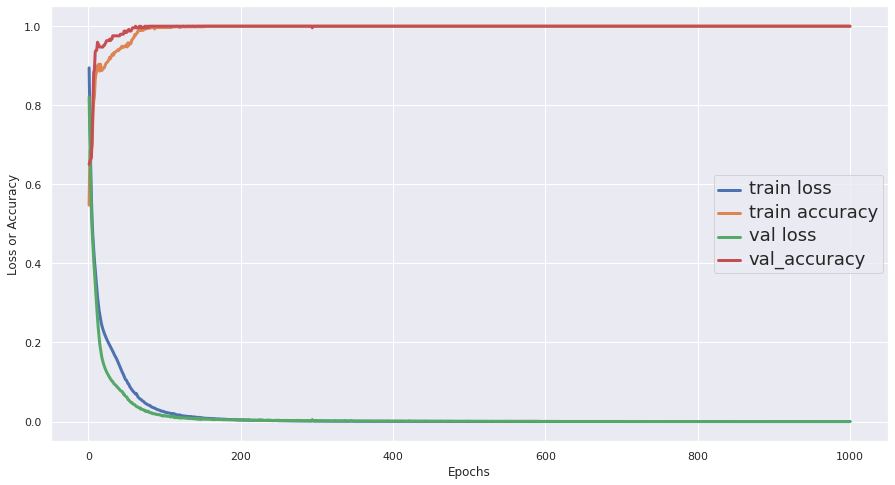

In [65]:
# plot the performance
epoch_num = range(1,epochs+1)
loss = H.history['loss']
accuracy = H.history['accuracy']
val_loss = H.history['val_loss']
val_accuracy = H.history['val_accuracy']
plot_df = pd.DataFrame(data=np.c_[epoch_num,
                                  loss,accuracy,
                                  val_loss,
                                  val_accuracy],
                       columns=['epochs','loss', 'accuracy', 'val_loss', 'val_accuracy'])

# do the actual plots
sns.set(font_scale=1)
f, ax = plt.subplots(1, 1, figsize=(15,8))
sns.lineplot(data=plot_df, x='epochs', y='loss', ax=ax, label='train loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='accuracy', ax=ax, label='train accuracy', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_loss', ax=ax, label='val loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_accuracy', ax=ax, label='val_accuracy', linewidth=3)
ax.set_ylabel('Loss or Accuracy')
ax.set_xlabel('Epochs')
plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text

In [66]:
# calculate the classification report
from sklearn.metrics import classification_report
preds = model.predict(testx)
print(classification_report(testy.argmax(axis=1),
                            preds.argmax(axis=1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        69
           1       1.00      1.00      1.00        81
           2       1.00      1.00      1.00        96

    accuracy                           1.00       246
   macro avg       1.00      1.00      1.00       246
weighted avg       1.00      1.00      1.00       246



#PCA

In [67]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_transformed_x = pca.fit_transform(X)
pca.explained_variance_ratio_

array([0.90272509, 0.08227698])

In [68]:
pca_df = pd.DataFrame(data=np.c_[pca_transformed_x, Y['Biomaterial']],
                       columns=['x1','x2', 'Biomaterial'])
pca_df.head()

,x1,x2,Biomaterial
0,-1.66211,0.135679,Collagen
1,-1.82359,0.110448,Collagen
2,-1.74587,0.0749063,Collagen
3,-1.8552,0.0497896,Collagen
4,-1.93653,-0.0566449,Collagen


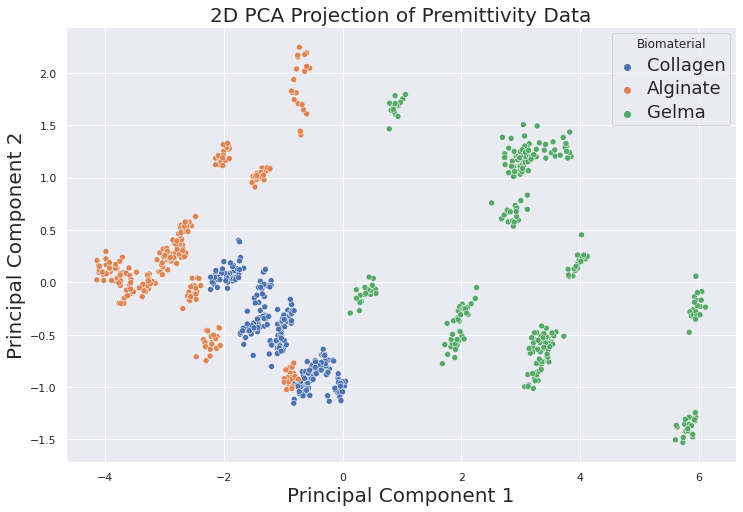

In [69]:
f, ax = plt.subplots(1,1, figsize=(12,8))
sns.scatterplot(data=pca_df, x='x1', y='x2', hue='Biomaterial', ax=ax)
ax.set_xlabel("Principal Component 1", fontsize=20)
ax.set_ylabel("Principal Component 2", fontsize=20)
ax.set_title("2D PCA Projection of Premittivity Data", fontsize=20)
plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text